In [68]:
import tifffile as tf
import numpy as np
import matplotlib.pyplot as plt
from read_roi import read_roi_zip
from scipy.odr import *
from scipy import special
import math
from skimage.transform import rotate
from lmfit import Model
from lmfit import Parameter
import csv
import os


pixelsize = 107 #nm on T2
psf = 306/2.355 #nm on T2

[[(54, 64), (13, 21)], [(86, 76), (37, 52)], [(64, 66), (64, 83)], [(14, 33), (106, 103)]]
['0018-0059', '0045-0081', '0074-0066', '0105-0023']


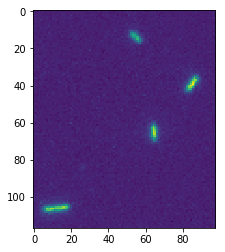

In [23]:
#Import image of seeds and positions of ROIs over seeds

im_path = 'D:/Claire/Practice Image/4seeds.tif'
roipath = 'D:/Claire/Practice Image/4seeds.zip'

im = tf.imread(im_path)
rois = read_roi_zip(roipath)

imstack =[]

#Turn im(numpy array) into a list
for i in im: 
    imstack.append(i)

#show image
plt.figure()
plt.imshow(imstack)

#Extract positional information of ROIs from zip file
roi_raw = [[k,v] for k, v in rois.items()]

roi_values = []
roi_names = []
for i in np.arange(0, len(roi_raw)):
    roi_values.append([(int(roi_raw[i][1]['x1']), int(roi_raw[i][1]['x2'])),
                       (int(roi_raw[i][1]['y1']), int(roi_raw[i][1]['y2']))])
    roi_names.append(roi_raw[i][0])

    #Roi poisitions stored as (x1, x2), (y1,y2)
print(roi_values)
print(roi_names)



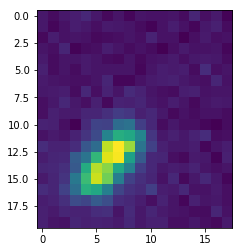

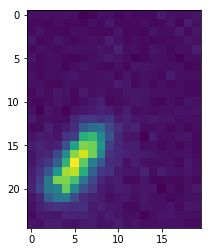

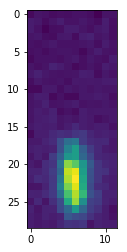

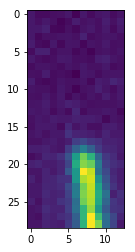

In [24]:
#Crop the field of view into small images of each individual seed
def cropimage(image,ROIs):
    extrapixels=5
    seeds=[]
    for r in ROIs:
        x1 = r[0][0]   #getting the x and y coordinates for each ROI
        x2 = r[0][1] 
        y1 = r[1][0] 
        y2 = r[1][1] 
        
        
        angle = math.degrees(math.atan2(y2-y1, x2-x1)) #calculate the angle of the ROI line 
        #**The position axes of the image go from 0 to X from left to right and 0 to Y from up to down rather than down to up like in a graph.
        
        imcropped=[] 
        for i in np.arange((min(y1, y2) - extrapixels), (max(y1, y2) + extrapixels)): #Cropping around the ROI + extrapixels all around 
            small=[]
            for s in np.arange((min(x1, x2) - extrapixels), (max(x1, x2) + extrapixels)): 
                small.append(image[i][s])
            imcropped.append(small) 
            
        
        #print(angle) 
        if x2 > x1 and angle < 45: 
            imcropped = np.rot90(imcropped)
            
        if x2 < x1 and angle < -135 or 135 < angle < 180: 
            imcropped = np.rot90(imcropped,3)
        
        if y2> y1 and 45 < angle < 135: 
            imcropped = np.rot90(imcropped,2)
        
     
        seeds.append(imcropped)
    return(seeds)


seeds = cropimage(imstack, roi_values)

for i in seeds: 
    plt.figure()
    plt.imshow(i)

In [25]:
#Fitting each row of each image to a gaussian wall. 

from lmfit import Parameter
from lmfit import Model

def gaussianwall(x, mu, sigma, mt, bg):
    gauss = []
    for i in x: 
        gauss.append(mt*np.exp((-1/2)*((i-mu)/sigma)**2)+bg)
                    
    return(gauss)
      

def peakfinder(seeds):
    allfits = []
    allparams = []
    
    for i in seeds: #for each image i
        fits = []
        fitparams =[]
        for r in i: # for each row r
            ylist = r 
            xlist = np.arange(0, pixelsize*len(ylist), pixelsize)
            weights = []
            for v in r:
                if v > 90:
                    weights.append(1) #ignores very small values (especially important when dealing with rotated images that have extra zero pixels to mainting the shape)
                else:
                    weights.append(0)
            
            gmodel= Model(gaussianwall)
            
            result = gmodel.fit(ylist, x = xlist, weights = weights,
                                mu = Parameter('mu', value = len(r)*pixelsize/2, vary = True, min = 0, max = len(r)*pixelsize), 
                                sigma = Parameter('sigma', value = 100, vary = True, min = 0, max = len(r)*pixelsize),
                                mt = Parameter('mt', value = 100, vary = True, min = 0),
                                bg = Parameter('bg', value = 100, vary = True, min = 0))
            fits.append(result.best_fit)
            fitparams.append([result.values['mu'], 
                            result.values['sigma'], 
                            result.values['mt'],
                            result.values['bg']])
        allfits.append(fits)
        allparams.append(fitparams)
        
    return(allfits, allparams)


allfits, allparams = peakfinder(seeds)

In [26]:
#Find the position of the peak of each gaussian. Keep only images where a peak was detected. 

def peakpositions(fitparams,seeds,roinames):
    peaks_x = []
    peaks_y = []
    real_seeds = []
    rois = []
    for n,i in enumerate(fitparams): 
        mu_of_images = []
        peak_y_image = []
    
        for a,r in enumerate(i):
                   
            if (r[2] + r[3] )> 200: #arbitrary threshold at the moment (intensity must be >200 to be considered a MT)
                mu_of_row = r[0]    
                mu_of_images.append(mu_of_row/pixelsize)
                peak_y_image.append(a)
                
                
            else: 
                continue
        
        
        if len(peak_y_image)>2: #Keeps only images where the fit is determined by more than two peak points
            real_seeds.append(seeds[n])
            rois.append(roinames[n])
            peaks_x.append(mu_of_images)
            peaks_y.append(peak_y_image)
        else:
            continue
        
        
    return(peaks_x, peaks_y,real_seeds,rois)

peaks_x, peaks_y, seeds, roi_names = peakpositions(allparams,seeds, roi_names)

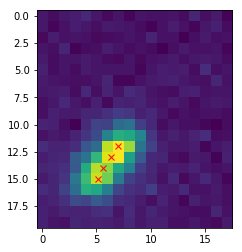

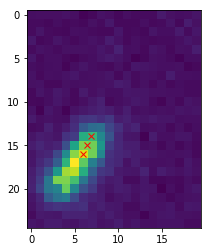

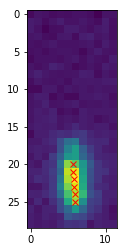

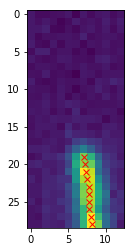

In [28]:
#Check that peaks detected overlap with the MT

for n in [0,1,2,3]: #pick a few arbitrary positions for long lists of images
    plt.figure()

    plt.imshow(seeds[n])
    plt.plot(peaks_x[n],peaks_y[n], 'rx') 

In [31]:
# Define the linear fitting function 

def lin_func(p, x):
     m, c = p
     return(m*x + c)
 
# Create a model for fitting.
lin_model = Model(lin_func)

def fitpeaks(xvals, yvals):
    x = xvals
    y = yvals
    # Create a RealData object using our initiated data from above.
    data = RealData(x, y) #sx=x_err,
    
    # Set up ODR with the model and data.
    odr = ODR(data, lin_model, beta0=[0., 1.])
     
    # Run the regression.
    out = odr.run()
     
    # Use the in-built pprint method to give us results.
    out.pprint()
     
    x_fit = np.linspace(x[0], x[-1], 2)
    y_fit = lin_func(out.beta, x_fit)
    
    return(x_fit, y_fit)


In [32]:
#Fit a line through the peaks of the gaussians in each image

import numpy as np
import matplotlib.pyplot as plt
from scipy.odr import *

def lin_func(p, x):
     m, c = p
     return(m*x + c)

# Create a model for fitting.
lin_model = Model(lin_func)
#Apply linear fit function to each seed 
xfits = []
yfits = []

for a in zip(peaks_x, peaks_y, seeds):
    
        x = a[0]
        y = a[1]   
        xfit_im, yfit_im = fitpeaks(x, y)
        xfits.append(xfit_im)
        yfits.append(yfit_im)

Beta: [-1.58200692 22.98986619]
Beta Std Error: [0.09493227 0.57339925]
Beta Covariance: [[  1.75432526 -10.52353941]
 [-10.52353941  64.00245324]]
Residual Variance: 0.005137095262489067
Inverse Condition #: 0.04602118895181214
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-2.0628891  28.23154351]
Beta Std Error: [0.00385371 0.02476504]
Beta Covariance: [[ 11.18245977 -71.72523384]
 [-71.72523384 461.80349612]]
Residual Variance: 1.328070142814105e-06
Inverse Condition #: 0.024680685931801297
Reason(s) for Halting:
  Sum of squares convergence
Beta: [ 20.05262357 -92.97996406]
Beta Std Error: [ 4.53328328 26.10933325]
Beta Covariance: [[  9262.43098016 -53340.90990597]
 [-53340.90990597 307249.2489917 ]]
Residual Variance: 0.0022187109808859368
Inverse Condition #: 0.005433455768695653
Reason(s) for Halting:
  Sum of squares convergence
Beta: [  9.30791744 -47.87986634]
Beta Std Error: [0.70321983 5.39716452]
Beta Covariance: [[  92.03314969 -705.77702241]
 [-705.77702241

In [33]:
#Calculate the angle of the MT and rotate the image according to this angle such
#that they all point in the same direction


def alignMTs(seeds,xfits, yfits):
    alignedseeds = []
    
    for s, x, y in zip(seeds, xfits, yfits):
        o = y[1] - y[0]
        a = x[1] - x[0]
        
        angle = math.atan2(o,a)
        image = np.array(s)
        im_rotate = rotate(image, (math.degrees(angle)+90), preserve_range = True)
        alignedseeds.append(im_rotate)
        
        
    return(alignedseeds)

seeds_rotated = alignMTs(seeds, xfits, yfits)

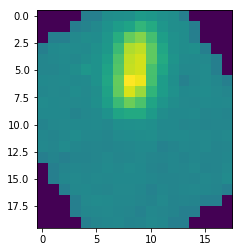

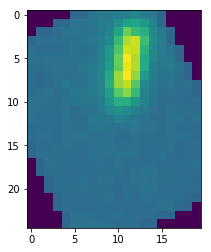

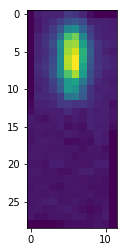

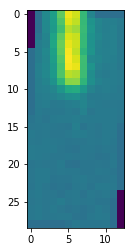

In [36]:
#Check that the images are properly rotated
for i in seeds_rotated:
    plt.figure()
    plt.imshow(i)

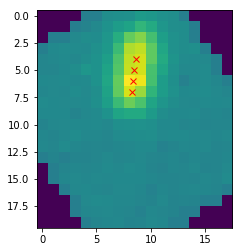

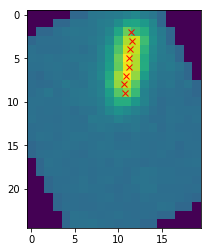

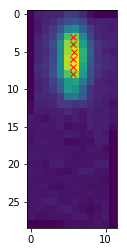

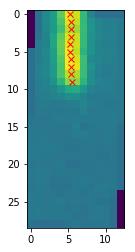

In [63]:
#Determine the center of the rotated microtubule by finding the peak of a gaussian wall

newfits, newparams = peakfinder(seeds_rotated)  

newpeaks_x, newpeaks_y, newseeds, new_roi_names = peakpositions(newparams, seeds_rotated, roi_names)
    
peaks_x = []
peaks_y = []
seeds = []
fitparams = []

for a in zip(newpeaks_x, newpeaks_y, newseeds, newparams):
    
    if len(a[0]) > 2:
        if max(a[0])-min(a[0]) <= 3 :
            peaks_x.append(a[0])
            peaks_y.append(a[1])
            seeds.append(a[2])
            fitparams.append(a[3])

realparams = []
        
for n, i in enumerate(peaks_y):
    im_params = []
    for a in zip(i, fitparams[n]):
        im_params.append(a[1])
    realparams.append(im_params)


#Check the position of the new peaks on the rotated seeds
for n,i in enumerate(seeds):
    plt.figure()
    plt.imshow(i)
    plt.plot(peaks_x[n], peaks_y[n], 'rx')
    

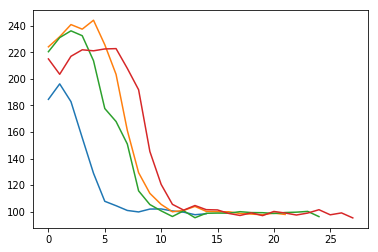

In [64]:
#Get the intensity profile along the microtubule end. Average 3 pixels wide.

MT = []

for n,i in enumerate(seeds):
    if np.mean(i) > 60: #avoids images that are just noise
        singleMT = []
        for a,r in enumerate(i):
            if a > peaks_y[n][0] : #ignore first few pixels in y direction
                center = int(np.around(np.mean(peaks_x[n]),0))
                pixelrange = [r[center-1], r[center], r[center+1]] #average of 3 pixels
                singleMT.append(np.mean(pixelrange))
            
        MT.append(singleMT)

for i in MT:
    plt.plot(i)

In [65]:
#save plot profiles as csv files

csvData = MT
with open('D:/Claire/Practice Image/ProfileTest.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)
csvFile.close()



In [66]:
#Find taper of MT ends by fitting intensity profiles 

#To read the data in the csv files
def readcsv(filename):
    ifile = open(filename)
    reader = csv.reader(ifile, delimiter = ',', quoting = csv.QUOTE_NONNUMERIC)
    rownum = 0
    a = []
    
    for n,row in enumerate(reader):
        if n%2 == 0:
            a.append(row)
            rownum += 1
    
    ifile.close()
    return a


#MT end can be fit to the error function or gaussian decay (half-gaussian) function

def errorfunction(x,mu,sigma,mt,bg):
    a = bg+(0.5*mt*special.erfc((x-mu)/(np.sqrt(2)*sigma)))    
    return(a)

def gaussian_decay(x, mu, sigma,mt,bg):
    gauss = []
    for i in x:
        if i < mu:
            gauss.append(mt+bg)
        else:
            gauss.append(mt*np.exp((-1/2)*((i-mu)/sigma)**2)+bg)
    return(gauss)

#fitting function
def sigmafinder(endprofiles):
    allfits = []
    allparams = []
    
    for i in endprofiles:
        if len(i)> 3:
            ylist = i
            xlist = np.arange(0,pixelsize*len(ylist), pixelsize)
            weights = []
            for v in i:
                if v > 90:
                    weights.append(1)
                else:
                    weights.append(0)
                    
            gmodel = Model(errorfunction) #chose errorfunction or gaussian decay to fit ends
            
            result = gmodel.fit(ylist, x = xlist, 
                                    mu = Parameter('mu', value = len(i)*pixelsize/2, vary = True, min = 0, max = len(i)*pixelsize), 
                                    sigma = Parameter('sigma', value = 100, vary = True, min = 0, max = len(i)*pixelsize),
                                    mt = Parameter('mt', value = 200, vary = True, min = 0),
                                    bg = Parameter('bg', value = 100, vary = True, min = 0))
            allfits.append(result.best_fit)
            allparams.append([result.values['mu'], 
                                result.values['sigma'], 
                                result.values['mt'],
                                result.values['bg']])
        
    return(allfits, allparams)

In [81]:
rootdirs = ['D:/Claire/Practice Image/Profiles'] #folder with only csv files

conditions = ['Test1']

MTends = []

for i in rootdirs:
    MTend_cond = []
    for fname in os.listdir(i):
            fpath = os.path.join(i, fname)            
            MTs = (readcsv(fpath))
            MTend_cond.append(MTs)
    MTends.append(MTend_cond)
    

allfits = []
allparams = []
allMTs = []

for i in MTends:
    ends = [y for x in i for y in x]
    fits, params = sigmafinder(ends)
    allfits.append(fits)
    allparams.append(params)
    
    good_ends = []
    for a in ends:
        if len(a) > 3:
            good_ends.append(a)
    allMTs.append(good_ends)    


#get sigma values from fits
sigmas = []
for i in allparams: 
    sigmas_condition=[]
    for a in i:
        if psf < a[1] < 3000:
            sigmas_condition.append(a[1])
    sigmas.append(sigmas_condition)    


print(sigmas)

[[144.70615500388226, 210.92819958134254]]


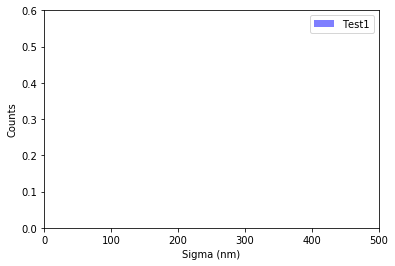

In [84]:
#Plot histogram of sigma values 

binsize = 50

for n,i in enumerate(sigmas):
    heights, bins = np.histogram(i, bins = int(max(i)/binsize))
    heights = heights/sum(heights)    
    plt.figure()
    plt.bar(bins[:-1], heights, width=(max(bins)-min(bins))/len(bins), alpha=0.5, color = 'b', label = conditions[n])
    plt.xlim(0,500)
    plt.ylim(0,0.60)
    plt.legend()
    plt.xlabel('Sigma (nm)')
    plt.ylabel('Counts')






